### Don't Overfit It Competition
##### Boris, Feb 20

https://www.kaggle.com/c/dont-overfit-ii/data

The following work inspired by Andrew Lukyanenko's kernel https://www.kaggle.com/artgor/how-to-not-overfit 

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import sklearn.preprocessing, sklearn.kernel_ridge, sklearn.model_selection, sklearn.linear_model
import multiprocessing
import seaborn as sns
import scipy.stats


In [70]:
submission = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f'Shape of the train {train.shape}')
print(f'Shape of the test {test.shape}')
test.head()


Shape of the train (250, 302)
Shape of the test (19750, 301)


,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


In [71]:
data = train.iloc[:, 2:].values
ref = train['target'].values
train['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

### The first shot: Logistic regression
We train the Logistic regression with different parameters, including optimizing the regularization strength

In [79]:
model_default = sklearn.linear_model.LogisticRegression()
model_default.fit(data, ref)

predict_test = model_default.predict_proba(test.iloc[:, 1:].values)
submission['target'] = predict_test
submission.to_csv('submission_logreg_default.csv', index=False)

model = sklearn.linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
model.fit(data, ref)

predict_test = model.predict_proba(test.iloc[:, 1:].values)
submission['target'] = predict_test
submission.to_csv('submission_logreg_l1.csv', index=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
def cross_validation(X, y, model, parameters, pname, nfold=10):
    cv_method = sklearn.model_selection.KFold(n_splits=nfold, shuffle=True, random_state=13)
    rgr = sklearn.model_selection.GridSearchCV(model, parameters, n_jobs=multiprocessing.cpu_count()-1, cv=cv_method, scoring='roc_auc')
    rgr.fit(X, y)
    plt.semilogx(parameters[pname], rgr.cv_results_['mean_test_score'], 'o-r')
    plt.xlabel(pname)
    plt.ylabel('ROC-AUC')
    plt.title(f'{nfold}-Fold cross validation')
    print(f"The best {pname} parameter is {rgr.best_params_[pname]}")
    return rgr


The best C parameter is 0.07896522868499725


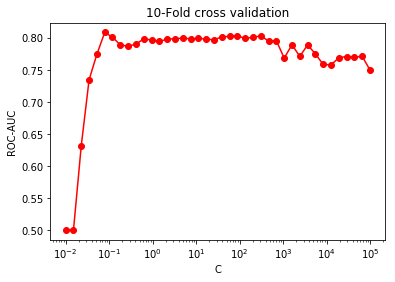

In [81]:
model = sklearn.linear_model.LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')
parameters = {'C': np.logspace(-2, 5, 40)}
rgr = cross_validation(data, ref, model, parameters, 'C', nfold=10)


In [82]:
predict_test = rgr.best_estimator_.predict_proba(test.iloc[:, 1:].values)
submission['target'] = predict_test
submission.to_csv('submission_logreg_cv_l1.csv', index=False)


Summarizing the results of submitting the LogisticRegression:
- A default Logistic regression trained on the train set and all the features gives 0.662 score in the leaderboard of the competition
- A Logistic regressoin with the parameters: 'class_weight='balanced', penalty='l1', C=0.1, solver='liblinear'' gives score of 0.752
- Optimizing the parameter C with the 10-fold cross-validation, improved the score to 0.755

### Next: Feature selection
